# **XGBoost**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV
import multiprocessing
import joblib
from xgboost import XGBClassifier
import preprocessing as pp

warnings.filterwarnings('ignore')

# Obtenemos los dataframes con los que trabajaremos

In [2]:
X, y = pp.get_X_y_from_dataset()

Hay un problema... la variable target "llovieron_hamburguesas_al_dia_siguiente" contiene NaNs (~2600). Esto es un problema a la hora de separar en train-valdev-holdout usando train_test_split si queremos preservar la proporción entre las clases del target en la partición (es decir, pasandole a esa función stratify=y). Como test-holdout nunca debe ver los datos de train o valdev, no deberíamos rellenar dichos NaNs usando datos de otras instancias (si no habría data leaks). Por ende, decidimos completar estos NaNs con la clase mayoritaria por lejos, el "no". 

In [3]:
y = pp.fill_nan_with_simple_imputer(y, ["llovieron_hamburguesas_al_dia_siguiente"], "most_frequent")

También no necesitamos la columna de id.

In [4]:
pp.drop_features(y, ['id']) 

## Separamos en train y test-holdout
Test-holdout lo usaremos como métrica del mejor de los 5 modelos, para tener una idea antes que salga a producción. Tomaremos un 10% para el holdout, y hacemos que sea stratificado, de forma que divida el train y holdout teniendo en cuenta la proporción de la variable target. Notar que usamos el mismo RANDOM_STATE para todos los train_test_splits de los modelos para poder reproducir las mismas condiciones, entrenando y evaluando sobre las mismas particiones.

In [5]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, random_state=pp.RANDOM_STATE, test_size=0.1, stratify=y
)

# Preprocesamiento y Feature Engineering

A diferencia de las implementaciones de SKLearn, el XGBoost de esta librería no necesita tener una variable target numérica. Por eso no la encodeamos. 

## Corregimos los valores erraticos del dataset

El feature presión_atmosférica_tarde tiene algunos valores erráticos. Los eliminamos y dejamos temporalmente como NaN, de forma de rellenarlos (o no) a posteriori.

In [6]:
err_values_presion_atm = ['10.167.769.999.999.900', '1.009.555']

pp.convert_values_to_nan(X_train, 'presion_atmosferica_tarde', err_values_presion_atm)

Ahora sí, podemos convertir este feature de object a float16.

In [7]:
X_train['presion_atmosferica_tarde'] = X_train['presion_atmosferica_tarde'].astype('float32')

Y ahora corregimos los valores erráticos de la nubosidad_tarde y nubosidad_temprano:

In [8]:
err_values_nubosidad = [9.0]

pp.convert_values_to_nan(X_train, 'nubosidad_tarde', err_values_nubosidad)
pp.convert_values_to_nan(X_train, 'nubosidad_temprano', err_values_nubosidad)

## Descartamos features irrelevantes

Descartamos los features que no resultan relevantes para el modelo.

In [9]:
pp.drop_features(X_train, [
    'dia',
    'barrio',
    'humedad_temprano',
    'temp_min',
    'rafaga_viento_max_direccion',
    'velocidad_viendo_tarde',
    'velocidad_viendo_temprano',
    'rafaga_viento_max_velocidad'
])

## Escalar las variables numericas

Escalamos las variables numericas para que esten todas dentro de un mismo parametro.

In [10]:
features_to_scale = ['horas_de_sol','humedad_tarde', 'mm_evaporados_agua', 
                     'mm_lluvia_dia', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde', 
                     'temp_max', 'temperatura_tarde', 
                     'temperatura_temprano']

X_train = pp.standard_scale(X_train, features_to_scale)
X_train.head()

,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,temp_max,temperatura_tarde,temperatura_temprano
32489,Norte,Nornoreste,NaN,-2.192918,144830,no,NaN,-0.280907,NaN,NaN,-0.221242,0.372084,1.541459,1.631562,1.385308
83946,Sureste,Sursureste,-0.904636,1.228314,87711,no,-0.690600,-0.280907,7.0,5.0,-0.235449,-0.260813,1.035333,0.895409,1.708862
21588,Sur,Estesureste,0.099665,-1.229190,136988,no,-0.353998,-0.280907,5.0,2.0,0.503062,0.498666,-0.131569,-0.172735,-1.110675
20436,Oestesuroeste,Oeste,-0.772491,0.794636,99850,si,0.126863,-0.042663,7.0,7.0,0.219020,-0.724935,-0.961053,-1.038798,-0.586826
105562,Oeste,Estesureste,0.707531,-1.132818,80032,no,-0.353998,-0.280907,7.0,4.0,0.829709,1.159694,0.219907,0.072650,-0.633048


## Aplicamos One Hot encoding a las variables categóricas no ordinales

In [11]:
X_train = pp.one_hot_encode(X_train, ['direccion_viento_tarde','direccion_viento_temprano', 'llovieron_hamburguesas_hoy'])
X_train.head()

,horas_de_sol,humedad_tarde,id,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,temp_max,...,direccion_viento_temprano_Oestenoroeste,direccion_viento_temprano_Oestesuroeste,direccion_viento_temprano_Sur,direccion_viento_temprano_Sureste,direccion_viento_temprano_Sursureste,direccion_viento_temprano_Sursuroeste,direccion_viento_temprano_suroeste,direccion_viento_temprano_nan,llovieron_hamburguesas_hoy_si,llovieron_hamburguesas_hoy_nan
32489,NaN,-2.192918,144830,NaN,-0.280907,NaN,NaN,-0.221242,0.372084,1.541459,...,0,0,0,0,0,0,0,0,0,0
83946,-0.904636,1.228314,87711,-0.690600,-0.280907,7.0,5.0,-0.235449,-0.260813,1.035333,...,0,0,0,0,1,0,0,0,0,0
21588,0.099665,-1.229190,136988,-0.353998,-0.280907,5.0,2.0,0.503062,0.498666,-0.131569,...,0,0,0,0,0,0,0,0,0,0
20436,-0.772491,0.794636,99850,0.126863,-0.042663,7.0,7.0,0.219020,-0.724935,-0.961053,...,0,0,0,0,0,0,0,0,1,0
105562,0.707531,-1.132818,80032,-0.353998,-0.280907,7.0,4.0,0.829709,1.159694,0.219907,...,0,0,0,0,0,0,0,0,0,0


## Completamos NaNs con la clase más frecuente

Realizamos este paso para tener el dataset lo mas completo posible y así poder trabajar con mas datos. 

In [12]:
X_train = pp.fill_nan_with_simple_imputer(X_train, X_train.columns, "most_frequent")

## Separamos en train y val-dev antes de hacer GridSearch

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train, 
                                                    test_size = 0.3, 
                                                    random_state = pp.RANDOM_STATE, 
                                                    stratify=y_train)

# Buscamos los mejores hiperparámetros
Utilizamos GS para iterar entre todos los parametros y CV de 5 folds para obtener el mejor resultado por sobre varios testeos.

Determinamos 
#### subsample -> [0.8, 0.4, 0.1]
#### learning_rate -> [0.001, 0.01, 0.04, 0.1, 0.15]
#### gamma -> [0,1,2]

In [14]:
%%script false --no-raise-error # Para no ejecutar este bloque
params = {'subsample': [0.8, 0.4, 0.1], 'learning_rate': [0.001, 0.01, 0.04, 0.1, 0.15], 'gamma': [0,1,2]}

clf = XGBClassifier()

gscv = GridSearchCV(
    clf, params, scoring='f1_micro', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

joblib.dump(gscv.best_estimator_, open("gridsearch_results/best_models/best_model_XGBoost.pickle", "wb"))

# Cargamos el modelo ya con los mejores hiperparámetros y lo entrenamos
Ya corrimos el GridSearch y nos guardamos el mejor clasificador que encontró. Carguémoslo y usemos ese. Entrenaremos este modelo pero en el X_train completo, para luego evaluarlo en X_test.

In [15]:
clf = joblib.load("gridsearch_results/best_models/best_model_XGBoost.pickle")
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
clf.fit(X_train, y_train)

[22:03:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Evaluamos en val-dev y medimos la performance

In [17]:
clf_pred = clf.predict(X_test)

### F1, Precision, Recall, Accuracy

In [18]:
f1_score(y_test, clf_pred, average='weighted')

0.8405340978533018

In [19]:
precision_score(y_test, clf_pred, average='weighted')

0.8419214638590963

In [20]:
recall_score(y_test, clf_pred, average='weighted')

0.8514322087842139

In [21]:
accuracy_score(y_test, clf_pred)

0.8514322087842139

### Confusion Matrix

In [22]:
clf_pred_proba = clf.predict_proba(X_test)
clf_pred_proba_pos = clf_pred_proba[:,1] 

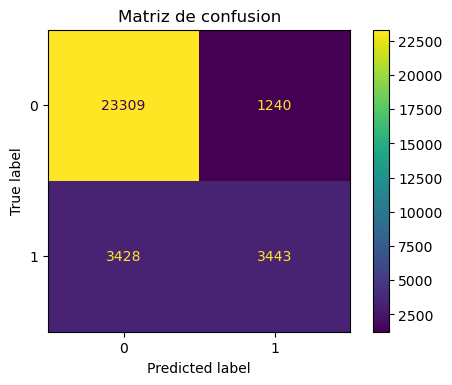

In [23]:
cm = confusion_matrix(y_test, clf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(dpi=100)
plt.title("Matriz de confusion")
disp.plot(ax=ax)

### AUC-ROC

In [24]:
def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(12, 8))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})'
    )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

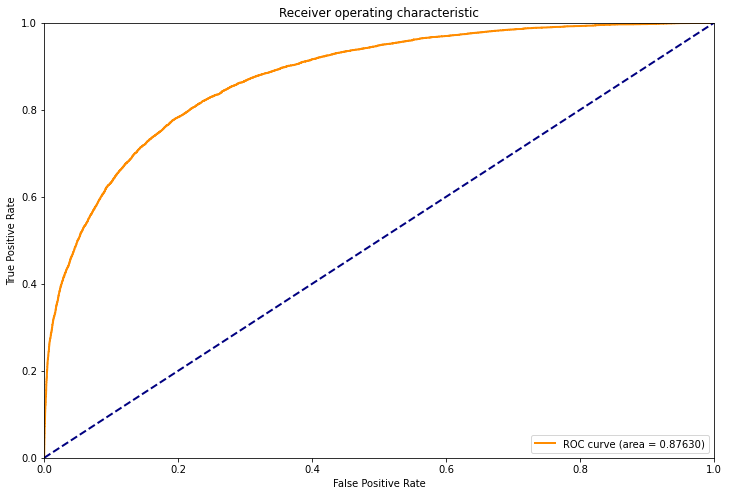

AUC_ROC:  0.8763011195552397


In [25]:
y_binary = pp.one_hot_encode(y_test, ['llovieron_hamburguesas_al_dia_siguiente'])
pp.drop_features(y_binary, ['llovieron_hamburguesas_al_dia_siguiente_nan'])
fpr, tpr, thresholds = roc_curve(y_binary, clf_pred_proba_pos)
plot_roc(fpr, tpr, thresholds)
print("AUC_ROC: ", roc_auc_score(y_binary, clf_pred_proba_pos))

# Predicción sobre los datos privados de Flint

Primero, hacemos el preprocesamiento de los datos, utilizando el mismo feature engineering que realizamos antes, para que el modelo pueda entender los datos que le pasamos. Luego, predecimos usando el modelo ya entrenado y finalmente guardamos los resultados.

In [26]:
X_private = pp.get_X_private_features()

In [27]:
def preprocess_X_for_XGBoost(X):
    X['presion_atmosferica_tarde'] = X['presion_atmosferica_tarde'].astype('float32')
    
    pp.drop_features(X, [
        'dia',
        'barrio',
        'humedad_temprano',
        'temp_min',
        'rafaga_viento_max_direccion',
        'velocidad_viendo_tarde',
        'velocidad_viendo_temprano',
        'rafaga_viento_max_velocidad'
    ])

    features_to_scale = ['horas_de_sol','humedad_tarde', 'mm_evaporados_agua', 
                     'mm_lluvia_dia', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde', 
                     'temp_max', 'temperatura_tarde', 
                     'temperatura_temprano']

    X = pp.standard_scale(X, features_to_scale)

    X = pp.one_hot_encode(X, ['direccion_viento_tarde','direccion_viento_temprano', 'llovieron_hamburguesas_hoy'])

    X = pp.fill_nan_with_simple_imputer(X, X.columns, "most_frequent")
    
    return X

In [28]:
X_private = preprocess_X_for_XGBoost(X_private)

In [29]:
xg_priv_feat_pred = clf.predict(X_private)

In [30]:
predictions = X_private.loc[:,['id']]
predictions["llovieron_hamburguesas_al_dia_siguiente"] = xg_priv_feat_pred
predictions = predictions.set_index('id')
predictions.head()

,llovieron_hamburguesas_al_dia_siguiente
id,
116706,no
58831,no
31981,si
2533,no
7270,si


In [31]:
predictions.to_csv('predicciones/XGBoost.csv')